In [1]:
import os
import cv2
import numpy as np
import random

data_dir = 'Data'
people = os.listdir(data_dir)

In [2]:
# Define the genuine people
genuine_people = ['Yasser_Arafat', 'Mahmoud_Abbas', 'Keanu_Reeves']

genuine_data = []
imposter_data = []

for person in people:
    # Limit the number of images for George W. Bush
    if person == 'George_W_Bush':
        image_files = os.listdir(os.path.join(data_dir, person))[:20]
    else:
        image_files = os.listdir(os.path.join(data_dir, person))

    for image_file in image_files:
        image = cv2.imread(os.path.join(data_dir, person, image_file), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64)).flatten()

        if person in genuine_people:
            genuine_data.append(image)
        else:
            imposter_data.append(image)

# Make sure to balance the dataset
imposter_data = random.sample(imposter_data, len(genuine_data))

data = genuine_data + imposter_data
labels = [0]*len(genuine_data) + [1]*len(imposter_data)  # 0 for genuine, 1 for imposter

In [3]:
# Normalize the data
data = np.array(data) / 255.0

# Check for class balance
genuine_count = labels.count(0)
imposter_count = labels.count(1)

print(f'Genuine count: {genuine_count}, Imposter count: {imposter_count}')

# If the data is imbalanced, you can balance it by undersampling or oversampling
if genuine_count != imposter_count:
    print('Data is imbalanced. Consider balancing the data.')

Genuine count: 48, Imposter count: 48


In [4]:
from sklearn.model_selection import train_test_split

# Convert data and labels to numpy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the SVM
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

# Create a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# Fit the model to the training data
grid.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.538 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.538 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.538 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.538 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.538 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.538 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [6]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = grid.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67        17
           1       0.54      0.58      0.56        12

    accuracy                           0.62        29
   macro avg       0.61      0.62      0.61        29
weighted avg       0.63      0.62      0.62        29


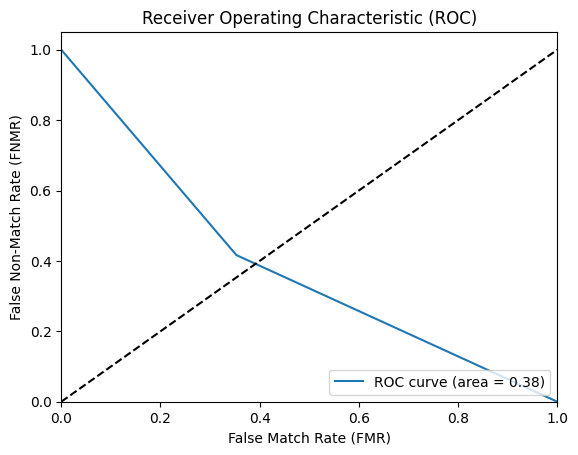

False Match Rate (FMR): [0.         0.35294118 1.        ]
False Non-Match Rate (FNMR): [1.         0.41666667 0.        ]
Equal Error Rate (EER): 0.35294117647058826


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Calculate the FMR and FNMR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fmr = fpr
fnmr = 1 - tpr

# Plot the ROC curve
plt.figure()
plt.plot(fmr, fnmr, label='ROC curve (area = %0.2f)' % auc(fmr, fnmr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('False Non-Match Rate (FNMR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Determine the EER
eer = fmr[np.nanargmin(np.absolute((fnmr - fmr)))]
print('False Match Rate (FMR):', fmr)
print('False Non-Match Rate (FNMR):', fnmr)
print('Equal Error Rate (EER):', eer)